In [4]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

def tavily_tool():
    return "42"

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str


from typing import Literal
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = ChatAnthropic(model="claude-3-5-sonnet-latest")


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})



from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm, tools=[tavily_tool], state_modifier="You are a researcher. DO NOT do any math."
)


def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()


<>:24: SyntaxWarning: invalid escape sequence '\`'
<>:24: SyntaxWarning: invalid escape sequence '\`'
<>:24: SyntaxWarning: invalid escape sequence '\`'
<>:24: SyntaxWarning: invalid escape sequence '\`'
/tmp/ipykernel_2641115/3043187516.py:24: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
/tmp/ipykernel_2641115/3043187516.py:24: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
/home/leo/.asdf/installs/python/3.12.6/lib/python3.12/site-packages/langchain_experimental/utilities/__init__.py:3: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain.pydantic_v1 import Bas

NameError: name 'ChatAnthropic' is not defined

In [2]:
import langgraph.version
langgraph.version.__version__

'0.2.66'

In [3]:
from langgraph.prebuilt.chat_agent_executor import AgentState
from langgraph.types import Command
from langchain_core.tools import tool
from langchain_core.tools.base import InjectedToolCallId
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableConfig
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import Any, Annotated
from langgraph.graph import END, MessagesState, StateGraph, START


class State(AgentState):
    # updated by the tool
    user_info: dict[str, Any] = {"puppa"}

USER_INFO = [
    {"user_id": "1", "name": "puppa", "location": "Rome"},
    {"user_id": "2", "name": "Taylor Swift", "location": "Beverly Hills, CA"},
]

USER_ID_TO_USER_INFO = {info["user_id"]: info for info in USER_INFO}


@tool
def lookup_user_info(
    tool_call_id: Annotated[str, InjectedToolCallId], config: RunnableConfig
) -> Command[Literal["state_modifier"]]:
    """Use this to look up user information to better assist them with their questions."""
    user_id = config.get("configurable", {}).get("user_id")
    if user_id is None:
        raise ValueError("Please provide user ID")

    if user_id not in USER_ID_TO_USER_INFO:
        raise ValueError(f"User '{user_id}' not found")

    user_info = USER_ID_TO_USER_INFO[user_id]
    return Command(
        update={
            # update the state keys
            "user_info": user_info,
            # update the message history
            "messages": [
                ToolMessage(
                    "Successfully looked up user information", tool_call_id=tool_call_id
                )
            ],
        },
        goto="state_modifier"
    )

tools = [lookup_user_info]

instructions = f"""

    ### AVAILABLE TOOLS
    - **middle**: Always use this tool to answer the user's question.

    """


def wrap_model(model: BaseChatModel) -> RunnableSerializable[AgentState, AIMessage]:
    model = model.bind_tools(tools)
    preprocessor = RunnableLambda(
        lambda state: [SystemMessage(content=instructions)] + state["messages"],
        name="StateModifier",
    )
    return preprocessor | model


def acall_model(state: AgentState, config: RunnableConfig) -> AgentState:
    m = ChatOpenAI(model="gpt-4o-mini")
    model_runnable = wrap_model(m)
    response = model_runnable.invoke(state, config)

    return {"messages": [response]}

def router(state: AgentState):
    return state["goto"]

# Define the graph
agent = StateGraph(AgentState)
agent.add_node("supervisor", acall_model)
agent.add_node("tools", ToolNode([middle]))
agent.add_node("answer", answer)
#agent.add_node("generate_definition", generate_definition)

# After "superviros", if there are tool calls, run "tools". Otherwise END.
def pending_tool_calls(state: AgentState) -> Literal["tools", "done"]:
    last_message = state["messages"][-1]
    if not isinstance(last_message, AIMessage):
        raise TypeError(f"Expected AIMessage, got {type(last_message)}")
    if last_message.tool_calls:
        return "tools"
    return "done"



agent.set_entry_point("supervisor")
#agent.add_conditional_edges("supervisor", pending_tool_calls, {"tools": "tools", "done": END})
# Always run "supervisor" after "tools"
#agent.add_edge("tools", "supervisor")
#agent.add_edge("tools", "answer")
agent.add_edge("supervisor", "tools")
agent.add_edge("answer", END)
#agent.add_conditional_edges("tools", router)
# Modify this for generation
#agent.add_conditional_edges("tools", router, {"answer": "answer", "generate_definition": "generate_definition"})



def state_modifier(state: State):
    user_info = state.get("user_info")
    if user_info is None:
        return state["messages"]

    system_msg = (
        f"User name is {user_info['name']}. User lives in {user_info['location']}"
    )
    return [{"role": "system", "content": system_msg}] + state["messages"]


from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI


#agent = create_react_agent(
    #model,
    ## pass the tool that can update state
    #[lookup_user_info],
    #state_schema=State,
    ## pass dynamic prompt function
    #state_modifier=state_modifier,
    #checkpointer=MemorySaver()
#)

agent = StateGraph(State)
agent.add_node("state_modifier", state_modifier)
agent.add_node("supervisor", acall_model)
agent.add_node("tools", ToolNode(tools))
agent.set_entry_point("state_modifier")
agent.add_edge("state_modifier", "supervisor")
agent.add_edge("tools", "supervisor")

"""
    - **generate_definition**
        You should always use the "definition_search" tool first. If the tool does not return any definitions, you should use this tool to generate a definition for the term. The tool will provide you with a generated definition for the term. When answering the user, you should specify that you couldn't find a definition for the term and that the definition is generated. Also provide the list of documents used to generate the definition.\n
"""

NameError: name 'Literal' is not defined

In [70]:
agent = create_react_agent(
    model,
    # pass the tool that can update state
    [lookup_user_info],
    state_schema=State,
    # pass dynamic prompt function
    #state_modifier=state_modifier,
    checkpointer=MemorySaver()
)

for chunk in agent.stream(
    {"messages": [("user", "hi, what should i do this weekend?")]},
    # provide user ID in the config
    {"configurable": {"user_id": "1", "thread_id": "1"}},
    stream_mode="values"
):
    print(chunk['messages'][-1].pretty_print())
    print("\n")

================================ Human Message =================================

hi, what should i do this weekend?
None


================================== Ai Message ==================================
Tool Calls:
  lookup_user_info (call_agESHi84Qsta5qadcsjGk7gK)
 Call ID: call_agESHi84Qsta5qadcsjGk7gK
  Args:
None


================================= Tool Message =================================
Name: lookup_user_info

Command(update={'user_info': {'user_id': '1', 'name': 'puppa', 'location': 'Rome'}, 'messages': [ToolMessage(content='Successfully looked up user information', tool_call_id='call_agESHi84Qsta5qadcsjGk7gK')]}, goto='state_modifier')
None


================================== Ai Message ==================================

Here are some suggestions for things to do in Rome this weekend:

1. **Visit the Colosseum**: Explore one of the most iconic landmarks in Rome. Consider booking a guided tour to learn about its history.

2. **Stroll through Trastevere**: This charming

In [66]:
for chunk in agent.compile(checkpointer=MemorySaver()).stream(
    {"messages": [("user", "hi, what should i do this weekend?")]},
    # provide user ID in the config
    {"configurable": {"user_id": "1", "thread_id": "1"}},
    stream_mode="values"
):
    print(chunk['messages'][-1].pretty_print())
    print("\n")

================================ Human Message =================================

hi, what should i do this weekend?
None


================================== Ai Message ==================================
Tool Calls:
  lookup_user_info (call_SD9A8jBU3XTlY9sQmavwAWfP)
 Call ID: call_SD9A8jBU3XTlY9sQmavwAWfP
  Args:
None




In [3]:
all_states = []
for state in agent.get_state_history(config = {"configurable": {"thread_id": "1"}}):
    print(state.values)
    all_states.append(state)
    print("--")

{'messages': [HumanMessage(content='hi, what should i do this weekend?', additional_kwargs={}, response_metadata={}, id='8941e998-e75d-450a-8fe2-885174334845'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_C6HLvVpzAWcqBB3E2ejZQajH', 'function': {'arguments': '{}', 'name': 'lookup_user_info'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 56, 'total_tokens': 68, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-228d924d-91f3-4e21-8660-a8f279896bf3-0', tool_calls=[{'name': 'lookup_user_info', 'args': {}, 'id': 'call_C6HLvVpzAWcqBB3E2ejZQajH', 'type': 'tool_call'}], usage_metadata={'input_tokens': 56, 'outpu

In [35]:
for el in all_states:
    print(el.metadata)

{'source': 'loop', 'writes': {'agent': {'messages': [AIMessage(content="Since you're in Rome, here are a few suggestions for things to do this weekend:\n\n1. **Explore Ancient Rome**: Visit iconic sites like the Colosseum, Roman Forum, and Palatine Hill. These historical landmarks offer a glimpse into the city's rich past.\n\n2. **Visit Vatican City**: Explore St. Peter’s Basilica and the Vatican Museums, including the Sistine Chapel. It's best to book tickets in advance.\n\n3. **Stroll Through Trastevere**: This charming neighborhood is perfect for a leisurely walk. Enjoy the narrow streets, beautiful squares, and local eateries.\n\n4. **Sample Italian Cuisine**: Treat yourself to some authentic Roman dishes like Carbonara or Cacio e Pepe at a traditional trattoria.\n\n5. **Attend a Local Event**: Check out local listings for any concerts, festivals, or art exhibitions happening this weekend.\n\n6. **Relax in a Park**: Spend some time in Villa Borghese or the Orange Garden for a peace

---

In [9]:

from typing_extensions import Literal
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.types import Command

model = ChatOpenAI(model="gpt-4o-mini")


@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help."""
    # This tool is not returning anything: we're just using it
    # as a way for LLM to signal that it needs to hand off to another agent
    # (See the paragraph above)
    return


@tool
def transfer_to_addition_expert():
    """Ask addition agent for help."""
    return


def addition_expert(
    state: MessagesState,
) -> Command[Literal["multiplication_expert", "__end__"]]:
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication. "
        "Always do your portion of calculation before the handoff."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = model.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    # If there are tool calls, the LLM needs to hand off to another agent
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        # NOTE: it's important to insert a tool message here because LLM providers are expecting
        # all AI messages to be followed by a corresponding tool result message
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
        )

    # If the expert has an answer, return it directly to the user
    return {"messages": [ai_msg]}


def multiplication_expert(
    state: MessagesState,
) -> Command[Literal["addition_expert", "__end__"]]:
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = model.bind_tools([transfer_to_addition_expert]).invoke(messages)
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="addition_expert", update={"messages": [ai_msg, tool_msg]})

    return {"messages": [ai_msg]}


builder = StateGraph(MessagesState)
builder.add_node("addition_expert", addition_expert)
builder.add_node("multiplication_expert", multiplication_expert)
# we'll always start with the addition expert
builder.add_edge(START, "addition_expert")
graph = builder.compile()


from langchain_core.messages import convert_to_messages


def pretty_print_messages(update):
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")

    for node_name, node_update in update.items():
        print(f"Update from node {node_name}:")
        print("\n")

        for m in convert_to_messages(node_update["messages"]):
            m.pretty_print()
        print("\n")

In [10]:
for chunk in graph.stream(
    {"messages": [("user", "what's (3 + 5) * 12")]},
):
    pretty_print_messages(chunk)


Update from node addition_expert:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_multiplication_expert (call_EjAsq8QU3nZNuX3Y2jMY7BrH)
 Call ID: call_EjAsq8QU3nZNuX3Y2jMY7BrH
  Args:
  transfer_to_multiplication_expert (call_ArVuarDevOTOfVbTrtrnbpFf)
 Call ID: call_ArVuarDevOTOfVbTrtrnbpFf
  Args:
================================= Tool Message =================================

Successfully transferred




BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_EjAsq8QU3nZNuX3Y2jMY7BrH", 'type': 'invalid_request_error', 'param': 'messages', 'code': None}}

---

In [157]:
from datetime import datetime
from typing import Annotated, Literal, Sequence, Dict, Any
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage

from langchain_community.tools import DuckDuckGoSearchResults, OpenWeatherMapQueryRun
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.messages import AIMessage, SystemMessage, ToolMessage
from langchain_core.runnables import RunnableConfig, RunnableLambda, RunnableSerializable
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.managed import RemainingSteps
from langgraph.prebuilt import ToolNode
from langgraph.types import Command
from typing_extensions import Any, Annotated
from langchain_core.tools.base import InjectedToolCallId
from langchain_core.messages import HumanMessage
from langchain_core.prompts import PromptTemplate
import asyncio

from langgraph.graph.message import add_messages
from LegalDefAgent.src.llm import get_model
from LegalDefAgent.src.settings import settings


# ---- tools

from langchain_core.tools import tool
from langgraph.prebuilt import tools_condition, ToolNode



from LegalDefAgent.src.definition_search import definition_search


# ---- agent

class AgentState(MessagesState, total=False):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    remaining_steps: RemainingSteps
    relevant_definitions: str
    definendum: str
    question: str
    goto: str

def answer(state: AgentState, config: RunnableConfig):
    response = state['relevant_definitions'] + "2"

    return {"messages": [response]}


def generate_definition(state: AgentState, config: RunnableConfig, definendum: str, question: str):
    """
    Generate a definition for a given term.

    Args:
        config (RunnableConfig): The configuration of the agent
        definendum (str): The term to define
        question (str): The question asked by the user
    
    Returns:
        str: The generated definition
    """

    model = get_model(config["configurable"].get("model", settings.DEFAULT_MODEL))

    prompt = PromptTemplate(
    template="""
        You are a lawyer and your job is to draft legal definitions.
        Provide a definition for the term "{definendum}" to answer the user's question provided below following the style and formatting of the definitions provided as examples.
        User Question: {question}
        Example definitions: 
        \n{examples}\n
        VERY IMPORTANT NOTES:
        * You should answer with "I couldn't find a definition for "{definendum}", so here's a generated one:" followed by the generated definition.
        """,
        input_variables=["question", "definendum", "examples"]
    )

    chain = prompt | model
    response = chain.invoke({"question": question, "definendum": definendum, "examples": state['relevant_defs']})

    return response.content

@tool(response_format="content_and_artifact")
def middle(state: AgentState, tool_call_id: Annotated[str, InjectedToolCallId]) -> Command[Literal["answer"]]:
    """
    ALWAYS Use this tool for calculations
    """
    result = "found"
    relevant_defs = "fiffa"
    return result, relevant_defs


@tool
def lookup_user_info(
    tool_call_id: Annotated[str, InjectedToolCallId], config: RunnableConfig
) -> Command[Literal["answer"]]:
    """Use this to look up user information to better assist them with their questions."""
    return Command(
        update={
            # update the state keys
            "relevant_definitions": "fiffa",
            # update the message history
            "messages": [
                ToolMessage(
                    "Successfully looked up user information", tool_call_id=tool_call_id
                )
            ],
        },
        goto="answer"
    )

def my_node(state: State) -> Command[Literal["answer"]]:
    return Command(
        # state update
        update={"relevant_definitions": "bar"},
        # control flow
        goto="answer"
    )


tools = [middle, lookup_user_info]

instructions = f"""
    You are an helpful assistant.

    ### AVAILABLE TOOLS
    - **middle**: Always use this tool to do calculations.
    - **lookup_user_info**: Use this tool to look up user information to better assist them with their questions.

    """


def wrap_model(model: BaseChatModel) -> RunnableSerializable[AgentState, AIMessage]:
    model = model.bind_tools(tools)
    preprocessor = RunnableLambda(
        lambda state: [SystemMessage(content=instructions)] + state["messages"],
        name="StateMod",
    )
    return preprocessor | model#preprocessor | model


def acall_model(state: AgentState, config: RunnableConfig) -> AgentState:
    m = get_model(config["configurable"].get("model", settings.DEFAULT_MODEL))
    model_runnable = wrap_model(m)
    response = model_runnable.invoke(state, config)

    if state["remaining_steps"] < 2 and response.tool_calls:
        return {
            "messages": [
                AIMessage(
                    id=response.id,
                    content="Sorry, need more steps to process this request.",
                )
            ]
        }
    
    return {"messages": [response]}


def router(state: AgentState):
    tool_msg = state["messages"][-1]
    print(state["relevant_definitions"])
    state["relevant_definitions"] = tool_msg.artifact
    print(state["relevant_definitions"])
    return Command(
        update={
            "relevant_definitions": "fiffola",
        },
        goto="answer"
    )

def node_1(state: AgentState):
    message_with_single_tool_call = AIMessage(
        content="",
        tool_calls=[
            {
                "name": "search",
                "args": {"location": "sf"},
                "id": "tool_call_id",
                "type": "tool_call",
            }
        ],
    )

    tool_node.invoke({"messages": [message_with_single_tool_call]})

# Define the graph
agent = StateGraph(AgentState)
agent.add_node("supervisor", acall_model)
agent.add_node("tools", ToolNode(tools))
agent.add_node("answer", answer)
agent.add_node("my_node", my_node)
agent.add_node("router", router)
agent.add_node("node_1", node_1)
agent.add_node("node_2", node_2)
#agent.add_node("generate_definition", generate_definition)

# After "superviros", if there are tool calls, run "tools". Otherwise END.
def pending_tool_calls(state: AgentState) -> Literal["tools", "done"]:
    last_message = state["messages"][-1]
    if not isinstance(last_message, AIMessage):
        raise TypeError(f"Expected AIMessage, got {type(last_message)}")
    if last_message.tool_calls:
        return "tools"
    return "done"



agent.set_entry_point("node_1")
#agent.add_conditional_edges("supervisor", pending_tool_calls, {"tools": "tools", "done": END})
# Always run "supervisor" after "tools"
#agent.add_edge("tools", "supervisor")
#agent.add_edge("tools", "answer")
agent.add_edge("supervisor", "tools")
#agent.add_conditional_edges("tools", router)
#agent.add_edge("tools", "router")
#agent.add_edge("supervisor", "my_node")
agent.add_edge("answer", END)
#agent.add_conditional_edges("tools", router)
# Modify this for generation
#agent.add_conditional_edges("tools", router, {"answer": "answer", "generate_definition": "generate_definition"})


definitions_agent = agent.compile(checkpointer=MemorySaver())


In [156]:
for chunk in definitions_agent.stream(
    {"messages": [("user", "what's 2+2?")], "relevant_definitions": "pera"},
    # provide user ID in the config
    {"configurable": {"user_id": "1", "thread_id": "1"}},
    stream_mode="values",
):
    print(chunk['messages'][-1].pretty_print())
    print("\n")

================================ Human Message =================================

what's 2+2?
None


================================== Ai Message ==================================
Tool Calls:
  middle (call_jaARsKzfFYsagbb7Wd2tn9ae)
 Call ID: call_jaARsKzfFYsagbb7Wd2tn9ae
  Args:
    state: {'messages': [{'content': '2 + 2', 'type': 'user'}]}
None


================================= Tool Message =================================
Name: middle

found
None


pera
fiffa
================================= Tool Message =================================
Name: middle

found
None


================================ Human Message =================================

fiffola2
None




In [150]:
all_states = []
for state in definitions_agent.get_state_history(config = {"configurable": {"thread_id": "1"}}
):
    print(state.values)
    all_states.append(state)
    print("--")

{'messages': [HumanMessage(content="what's 2+2?", additional_kwargs={}, response_metadata={}, id='c33eae05-9717-499a-bad8-477320365cfa'), AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_FZ5DM44RnGfHYUyrp0ejcUqX', 'function': {'arguments': '{"state":{"messages":[{"content":"2 + 2","type":"user"}]}}', 'name': 'middle'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63'}, id='run-b3fdbd18-d6d9-4fa6-b297-dcc0f54ed8c2-0', tool_calls=[{'name': 'middle', 'args': {'state': {'messages': [{'content': '2 + 2', 'type': 'user'}]}}, 'id': 'call_FZ5DM44RnGfHYUyrp0ejcUqX', 'type': 'tool_call'}]), ToolMessage(content='found', name='middle', id='48eeb6a2-eea4-4c00-81bf-43182b72fc43', tool_call_id='call_FZ5DM44RnGfHYUyrp0ejcUqX', artifact='fiffa'), HumanMessage(content='pera2', additional_kwargs={}, response_metadata={}, id='dccb7351-1ed4-464c-8e41-83d1d60d572a')], 'releva

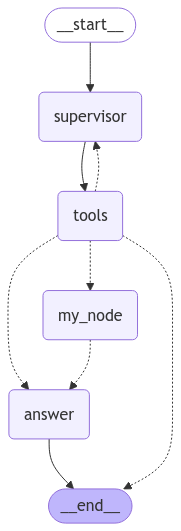

In [151]:
from LegalDefAgent.src.utils import draw_graph


draw_graph(definitions_agent)

In [20]:
from typing_extensions import TypedDict
from typing import Annotated, Literal, Sequence, Dict, Any
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage
from langgraph.graph.message import add_messages

@tool
def search(state: AgentState, tool_call_id: Annotated[str, InjectedToolCallId]):
    """
    Search for the definition.
    """
    print(state)
    return Command(
        update={"meaning_of_fun": "fishing",
                "messages": [ToolMessage("Successfully searched for the meaning of fun", tool_call_id=tool_call_id)]
                },
        goto="answer"
    )

model = ChatOpenAI(model="gpt-4o-mini")

tools = [search]
model_with_tools = model.bind_tools(tools)

def answer(state: AgentState):
    return {"messages": [AIMessage(content=f"The meaning of life is one {state["meaning_of_fun"]}")]}
    

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    meaning_of_fun: str


def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "answer"


def call_model(state: AgentState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("answer", answer)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
#workflow.add_edge("agent", "tools")

app = workflow.compile()

In [21]:
for chunk in app.stream(
    {"messages": [("user", "what's the definition of fun?")]},
    {"configurable": {"user_id": "1", "thread_id": "1"}},
    stream_mode="values",
):
    print(chunk['messages'][-1].pretty_print())
    print("\n")

================================ Human Message =================================

what's the definition of fun?
None


================================== Ai Message ==================================
Tool Calls:
  search (call_ZFu09f7ytVMWwhzdor9kcjFn)
 Call ID: call_ZFu09f7ytVMWwhzdor9kcjFn
  Args:
    state: {'messages': [{'content': "what's the definition of fun?", 'type': 'user'}], 'meaning_of_fun': 'definition'}
None


{'messages': [BaseMessage(content="what's the definition of fun?", additional_kwargs={}, response_metadata={}, type='user')], 'meaning_of_fun': 'definition'}
================================= Tool Message =================================
Name: search

Successfully searched for the meaning of fun
None


================================== Ai Message ==================================

The meaning of life is one fishing
None




In [13]:
all_states = []
for state in app.get_state_history(config = {"configurable": {"thread_id": "1"}}
):
    all_states.append(state)

for state in all_states:
    print(state.values)

{'messages': [HumanMessage(content="what's the definition of fun?", additional_kwargs={}, response_metadata={}, id='558d8475-959c-41e0-a0c6-51b1fc0b20ee'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_IZsGTnuuXjKMengQSUgZMuJH', 'function': {'arguments': '{"state":{"messages":[{"content":"what\'s the definition of fun?","type":"user"}]}}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 110, 'total_tokens': 141, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c1f65fe9-a536-4a0e-8c59-bbd851a11834-0', tool_calls=[{'name': 'search', 'args': {'state': {'messages': [{'content': "what's the de